In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Constructing the DataLoader

The PyTorch [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class is an efficient implementation of an iterator that can perform useful preprocessing and returns batches of elements. Here, we use its ability to batch and shuffle data, but DataLoaders are capable of much more.

Note that each time we iterate over a DataLoader, it starts again from the beginning.

Below we use `torchvision.utils.make_grid()` to show a sample batch of inputs.

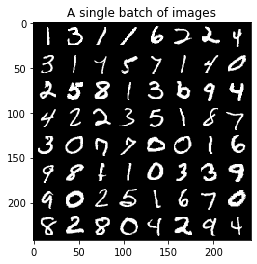

In [3]:
data_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)

# Show one batch of images. Each batch of images has shape [batch_size, 1, 28, 28],
# where 1 is the "channels" dimension of the image.
for images,labels in data_loader:
    grid_img = torchvision.utils.make_grid(images)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("A single batch of images")
    break

### Defining the Network
Here we define a simple 1-hidden-layer neural network for classification on MNIST. It takes a parameter that determines the hidden size of the hidden layer.

In [4]:
class MNISTNetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear_0 = nn.Linear(784, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, 10)

    def forward(self, inputs):
        x = self.linear_0(inputs)
        x = torch.sigmoid(x)
        return self.linear_1(x)

### Instantiating the Networks

We will consider three networks.

1. One that only has a single hidden unit and all of its weights are initialized to exactly 0.
2. One that has 64 hidden units and all of its weights are initialized to exactly 0.
3. One that has 64 hidden units and the weights are initialized using Torch's default, [Kaiming Uniform initialization](https://pytorch.org/docs/stable/nn.init.html).

In the code below, we utilize some important PyTorch methods which you'll want to be familiar with. This includes:

* [`torch.nn.Module.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): Returns an iterator over module parameters (i.e. for passing to an optimizer that will update those parameters).

* [`torch.Tensor.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html): Returns a *view* into the original Tensor. The result of this method shares the same underlying data as the input Tensor. This avoids copying the data, which means it can be mnore efficient, but it also means that when the original Tensor is modified, so is the view!

* [`torch.Tensor.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item): Returns the value of a single-element Tensor as a standard Python number. This only works for tensors with one element. For other cases, see `torch.Tensor.tolist()`.

* [`torch.Tensor.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html): Computes the gradients of current tensor wrt the graph leaves (note that this is only called if `Tensor.requires_grad` is True, which is the case by default). After calling this, a Tensor's `.grad` attribute is updated with the current gradients. These are used, for example, when calling `.step()` method of an optimizer.

* [`torch.optim.Optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html): Sets the gradients of all variables to zero. This should be conducted before each step of an optimization procedure (i.e., for each batch of training a DNN). If `.zero_grad()` is not called, gradients accumulate (add) over iterations.

In [5]:
small_net = MNISTNetwork(1)
large_net = MNISTNetwork(64)
large_net_rand = MNISTNetwork(64)

In [6]:
for p in zip(small_net.parameters(), large_net.parameters()):
    p1, p2 = p
    p1.data = torch.zeros_like(p1.data)
    p2.data = torch.zeros_like(p2.data)

### Training

We will train all three networks simulateneously using the same learning rate. After each epoch, we print the current loss of each network.

In [7]:
epochs = 32

optimizer_small = optim.Adam(small_net.parameters(), lr=5e-3)
optimizer_large = optim.Adam(large_net.parameters(), lr=5e-3)
optimizer_large_rand = optim.Adam(large_net_rand.parameters(), lr=5e-3)

for i in range(epochs):
    loss_small_epoch = 0.
    loss_large_epoch = 0.
    loss_large_rand_epoch = 0.

    for batch in tqdm(data_loader):
        images, labels = batch
        images, labels = images, labels

        images = images.view(-1, 784)

        optimizer_small.zero_grad()
        optimizer_large.zero_grad()
        optimizer_large_rand.zero_grad()

        y_small = small_net(images)
        y_large = large_net(images)
        y_large_rand = large_net_rand(images)

        loss_small = F.cross_entropy(y_small, labels)
        loss_large = F.cross_entropy(y_large, labels)
        loss_large_rand = F.cross_entropy(y_large_rand, labels)

        loss_small_epoch += loss_small.item()
        loss_large_epoch += loss_large.item()
        loss_large_rand_epoch += loss_large_rand.item()

        loss_small.backward()
        loss_large.backward()
        loss_large_rand.backward()

        optimizer_small.step()
        optimizer_large.step()
        optimizer_large_rand.step()

    print("Small Loss:", loss_small_epoch / len(data_loader))
    print("Large Loss:", loss_large_epoch / len(data_loader))
    print("Large rand Loss:", loss_large_rand_epoch / len(data_loader))

  1%|▏         | 14/938 [00:00<00:06, 132.26it/s]

Small Loss: 1.9587256841059686
Large Loss: 1.7745128125270038
Large rand Loss: 0.3280608507909818


  1%|▏         | 14/938 [00:00<00:06, 135.99it/s]

Small Loss: 1.7737967303312663
Large Loss: 1.5900255130298102
Large rand Loss: 0.14738429691205654


  1%|▏         | 14/938 [00:00<00:06, 133.76it/s]

Small Loss: 1.7433494847974798
Large Loss: 1.5459620207865863
Large rand Loss: 0.10775793077491684


  1%|▏         | 14/938 [00:00<00:06, 133.15it/s]

Small Loss: 1.7261587381362915
Large Loss: 1.5282881936030601
Large rand Loss: 0.08545428157192288


  1%|▏         | 14/938 [00:00<00:06, 132.27it/s]

Small Loss: 1.7023159632804805
Large Loss: 1.5167500627066282
Large rand Loss: 0.07004905668204464


  1%|▏         | 13/938 [00:00<00:07, 129.91it/s]

Small Loss: 1.6641317056948697
Large Loss: 1.5136075140570782
Large rand Loss: 0.059345477057108555


  1%|▏         | 14/938 [00:00<00:06, 135.04it/s]

Small Loss: 1.6258926478021942
Large Loss: 1.5090830046484973
Large rand Loss: 0.05033096056759183


  1%|▏         | 14/938 [00:00<00:06, 135.47it/s]

Small Loss: 1.5994021535428093
Large Loss: 1.508608175874519
Large rand Loss: 0.042943874230064245


  1%|▏         | 14/938 [00:00<00:06, 132.88it/s]

Small Loss: 1.5796918702532234
Large Loss: 1.5069093967297438
Large rand Loss: 0.036824142732751815


  1%|▏         | 14/938 [00:00<00:07, 130.97it/s]

Small Loss: 1.5664229624306978
Large Loss: 1.5060668877447083
Large rand Loss: 0.03243987539430399


  1%|▏         | 13/938 [00:00<00:07, 129.97it/s]

Small Loss: 1.554931192764087
Large Loss: 1.5017651839296955
Large rand Loss: 0.028768465723539555


  1%|▏         | 14/938 [00:00<00:06, 133.61it/s]

Small Loss: 1.548917906879108
Large Loss: 1.5043693043784039
Large rand Loss: 0.024412282263122396


  1%|▏         | 13/938 [00:00<00:07, 124.22it/s]

Small Loss: 1.5414712024904262
Large Loss: 1.5035205771928148
Large rand Loss: 0.02189796573200972


  1%|▏         | 14/938 [00:00<00:06, 137.14it/s]

Small Loss: 1.5375494153769032
Large Loss: 1.5008562691430294
Large rand Loss: 0.01894623269645948


  1%|▏         | 13/938 [00:00<00:07, 128.22it/s]

Small Loss: 1.531412535257685
Large Loss: 1.5034338205353792
Large rand Loss: 0.018614754631883525


  1%|▏         | 14/938 [00:00<00:06, 135.75it/s]

Small Loss: 1.528229622698542
Large Loss: 1.503543989744776
Large rand Loss: 0.014907297636528732


  1%|▏         | 14/938 [00:00<00:06, 134.63it/s]

Small Loss: 1.5232242671157252
Large Loss: 1.4992865616324613
Large rand Loss: 0.01603939932999886


  1%|▏         | 14/938 [00:00<00:06, 136.04it/s]

Small Loss: 1.5209439850565214
Large Loss: 1.503432981876422
Large rand Loss: 0.01294352805093879


  1%|▏         | 14/938 [00:00<00:06, 138.70it/s]

Small Loss: 1.5187395443794316
Large Loss: 1.5048486986902476
Large rand Loss: 0.012018826013193406


  1%|▏         | 14/938 [00:00<00:06, 135.61it/s]

Small Loss: 1.516594625485223
Large Loss: 1.5009127515973821
Large rand Loss: 0.013206768262236112


  1%|▏         | 14/938 [00:00<00:06, 136.53it/s]

Small Loss: 1.5152095646492199
Large Loss: 1.5028754297350007
Large rand Loss: 0.009027514214743364


  1%|▏         | 14/938 [00:00<00:06, 136.25it/s]

Small Loss: 1.513280823667929
Large Loss: 1.5030456924997668
Large rand Loss: 0.009645226461770533


  1%|▏         | 14/938 [00:00<00:06, 132.81it/s]

Small Loss: 1.5120938009798908
Large Loss: 1.5064712662432493
Large rand Loss: 0.014300291616756193


  1%|▏         | 13/938 [00:00<00:07, 128.74it/s]

Small Loss: 1.509151398373057
Large Loss: 1.5001873136329245
Large rand Loss: 0.008511717265653265


  1%|▏         | 14/938 [00:00<00:06, 134.18it/s]

Small Loss: 1.5082261666560224
Large Loss: 1.5033091652367923
Large rand Loss: 0.011354583858098807


  1%|▏         | 13/938 [00:00<00:07, 126.65it/s]

Small Loss: 1.5077407648568468
Large Loss: 1.5042249479019312
Large rand Loss: 0.0070929054787340845


  1%|▏         | 14/938 [00:00<00:06, 135.31it/s]

Small Loss: 1.5055585542975713
Large Loss: 1.5026128987259448
Large rand Loss: 0.007133544420805055


  1%|▏         | 14/938 [00:00<00:06, 135.60it/s]

Small Loss: 1.5050625329586997
Large Loss: 1.5013073985256367
Large rand Loss: 0.01227458695350529


  1%|▏         | 14/938 [00:00<00:06, 135.16it/s]

Small Loss: 1.503279219049889
Large Loss: 1.501281572303284
Large rand Loss: 0.006813468725602294


  1%|▏         | 14/938 [00:00<00:06, 135.11it/s]

Small Loss: 1.5038561934092913
Large Loss: 1.5012868485216901
Large rand Loss: 0.004904537462784019


  1%|▏         | 13/938 [00:00<00:07, 123.35it/s]

Small Loss: 1.5011934674879126
Large Loss: 1.500038178744855
Large rand Loss: 0.012681774872025015


100%|██████████| 938/938 [00:07<00:00, 128.10it/s]

Small Loss: 1.5027651303866778
Large Loss: 1.4997334257880253
Large rand Loss: 0.007204337094025057


In [8]:
W_0 = large_net.linear_0.weight
b_0 = large_net.linear_0.bias

W_1 = large_net.linear_1.weight
b_1 = large_net.linear_1.bias

In [9]:
print("W_0 => All weights equal for each hidden unit:", (W_0[0, :].unsqueeze(0) == W_0).all().item())
print("Example of weights:")
print(W_0[:, 256])

W_0 => All weights equal for each hidden unit: True
Example of weights:
tensor([-0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205,
        -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205, -0.0205],
       grad_fn=<SelectBackward>)


In [10]:
print("W_1 => All weights equal for each hidden unit:", (W_1[:, 0].unsqueeze(-1) == W_1).all().item())
print("Weights:")
print(W_1[8])

W_1 => All weights equal for each hidden unit: True
Weights:
tensor([-0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307,
        -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307, -0.3307],
       grad_fn=<SelectBackward>)


In [11]:
print("b_0 => All biases equal for each hidden unit:", (b_0[0] == b_0).all().item())
print("Bias:")
print(b_0)

b_0 => All biases equal for each hidden unit: True
Bias:
Parameter containing:
tensor([-1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652,
        -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652, -1.5652],
       requires_grad=True)


In [12]:
print("b_1 => All biases equal for each hidden unit:", (b_1[0] == b_1).all().item())
print("Bias:")
print(b_1)

b_1 => All biases equal for each hidden unit: False
Bias:
Parameter containing:
tensor([ 3.6663, -0.1765,  3.3811,  1.9363, -2.9802,  2.1906,  4.4735, -7.3658,
         1.9138, -5.0748], requires_grad=True)


## Tensor and Layer sizes

Below is an implementation of the network from the section handout. We use `torchinfo-summary()` to view the size of the data as it flows through the network; additionally, we print and the size of the weights and biases of the layers during a forward pass. Note that this network is just for demonstration and may not work well in practice.

*Note:* this section uses the [`torchinfo`](https://github.com/TylerYep/torchinfo) package; see the github repo for installation instructions or run one of the following lines below:

*install via conda*:
```
conda install -c conda-forge torchinfo
```

*install via pip*:
```
pip install torchinfo
```

In [15]:
from torchinfo import summary

class DemoNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.max1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 0)
        self.max2 = nn.MaxPool2d(2, 2, 1)
        self.conv3 = nn.Conv2d(32, 8, 1, 1, 0)
        self.conv4 = nn.Conv2d(8, 4, 5, 1, 0)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(36, 10)

    @property
    def trainable_layers(self):
        """A utility property to easily access a list of all model layers."""
        return [self.conv1, self.conv2, self.conv3, self.conv4, self.linear1]

    def forward(self, inputs):
        """Implements the forward pass."""
        x = self.conv1(inputs)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

    def print_weight_shapes(self):
        """Utility function to print the shapes of weights in trainable layers."""
        for layer in self.trainable_layers:
            print(f"Weight shape: {layer.weight.shape}; Bias shape: {layer.bias.shape}")

demo = DemoNetwork()
batch_size = 64
summary(demo, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
DemoNetwork                              [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 12, 12]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 8, 7, 7]             264
├─Conv2d: 1-6                            [64, 4, 3, 3]             804
├─Flatten: 1-7                           [64, 36]                  --
├─Linear: 1-8                            [64, 10]                  370
Total params: 6,238
Trainable params: 6,238
Non-trainable params: 0
Total mult-adds (M): 52.11
Input size (MB): 0.20
Forward/backward pass size (MB): 9.01
Params size (MB): 0.02
Estimated Total Size (MB): 9.23

In [16]:
demo.print_weight_shapes()

Weight shape: torch.Size([16, 1, 3, 3]); Bias shape: torch.Size([16])
Weight shape: torch.Size([32, 16, 3, 3]); Bias shape: torch.Size([32])
Weight shape: torch.Size([8, 32, 1, 1]); Bias shape: torch.Size([8])
Weight shape: torch.Size([4, 8, 5, 5]); Bias shape: torch.Size([4])
Weight shape: torch.Size([10, 36]); Bias shape: torch.Size([10])


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, test_data = torch.utils.data.random_split(mnist, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

epochs = 16
optimizer = optim.Adam(demo.parameters(), lr=5e-3)

for i in range(epochs):
    loss = 0.
    correct_labels = 0
    total_labels = 0

    for batch in tqdm(train_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        y_hat = demo(images)
        batch_loss = F.cross_entropy(y_hat, labels)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        correct_labels += torch.sum(torch.argmax(y_hat, dim=1) == labels).item()
        total_labels += len(labels)

    print("Train Loss:", loss / len(data_loader))
    print("Train Accuracy:", correct_labels / total_labels)


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [ ]:
with torch.no_grad():
    loss = 0.
    correct_labels = 0
    total_labels = 0
    for batch in tqdm(test_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        y_hat = demo(images)
        batch_loss = F.cross_entropy(y_hat, labels)

        loss += batch_loss.item()
        correct_labels += torch.sum(torch.argmax(y_hat, dim=1) == labels).item()
        total_labels += len(labels)

    print("Test Loss:", loss / len(data_loader))
    print("Test Accuracy:", correct_labels / total_labels)